Nice color picker to generate color schemes: https://coolors.co

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display,SVG
from matplotlib.ticker import MaxNLocator
from scipy.stats import entropy
import glob
import MESS
import numpy as np
import pandas as pd
import seaborn as sns
import collections

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

analysis_dir = "/home/juliette/Documents/internship_m1_MESS/MESS/fig2/"
analysis_dir_cont = "/home/juliette/Documents/internship_m1_MESS/MESS/fig2_cont/"


sp_dict = {"no":0, "lo":0.0005, "hi":0.005}
models = ["neutral", "competition", "filtering", "pairwise_competition"]


In [2]:
res = pd.read_csv(analysis_dir+'OUT_modif.txt', sep="\t", header=0)
res_cont = pd.read_csv(analysis_dir_cont+'OUT_modif.txt', sep="\t", header=0)

#display(res_cont)
MESS.plotting.model_colors
models

pw = res_cont[res_cont["competition"]>res_cont["filtering"]]
pw = pw[pw["competition"]>1-pw["filtering"]-pw["competition"]]

filt = res_cont[res_cont["competition"]<res_cont["filtering"]]
filt = filt[filt["filtering"]>1-filt["filtering"]-filt["competition"]]

neutral = res_cont[res_cont["competition"]<1-res_cont["competition"]-res_cont["filtering"]]
neutral = neutral[neutral["filtering"]<1-neutral["competition"]-neutral["filtering"]]
print(len(pw), len(filt), len(neutral))

286 292 277


In [37]:
%matplotlib inline
def plot_abundance(ax='', figsize=(5, 5), speciation_prob="no"):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    for m in models:
        simdir = analysis_dir + "{}_MESS/".format(m)

        logs = glob.glob("{}/*{}-*/*megalog.txt".format(simdir, speciation_prob))

        log_dat = [pd.read_csv(x)["abundance"].sort_values(ascending=False).values for x in logs]

        log_df = pd.concat(map(pd.Series, log_dat), axis=1)
#        mask = (log_df.notna().sum() >= 15) & (log_df.notna().sum() <= 16)
#        mask = (log_df.notna().sum() >= 5) & (log_df.notna().sum() <= 21)
#        log_df = log_df.loc[:, mask]

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))
        ax.plot(xs, np.log(means), c=MESS.plotting.model_colors[m])
        ax.plot(xs, np.log(means + stds), c=MESS.plotting.model_colors[m], ls='--')
        ax.plot(xs, np.log(np.clip(means - stds, 1, a_max=None)), color=MESS.plotting.model_colors[m], ls='--')
        ax.fill_between(xs, np.log(np.clip(means - stds, 1, a_max=None)), np.log(means + stds),
                        color=MESS.plotting.model_colors[m], alpha=0.25)
        
        
def plot_pi(ax='', figsize=(5, 5), speciation_prob="no"):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    for m in models:
        simdir = analysis_dir + "{}_MESS/".format(m)

        logs = glob.glob("{}/*{}-*/*megalog.txt".format(simdir, speciation_prob))

        log_dat = [pd.read_csv(x)["pi_local"].sort_values(ascending=False).values for x in logs]

        log_df = pd.concat(map(pd.Series, log_dat), axis=1)
#        mask = (log_df.notna().sum() >= 15) & (log_df.notna().sum() <= 16)
        mask = (log_df.notna().sum() >= 0) & (log_df.notna().sum() <= 21)
        log_df = log_df.loc[:, mask]

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))
        ax.plot(xs, means, c=MESS.plotting.model_colors[m])
        ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.plot(xs, means - stds, color=MESS.plotting.model_colors[m], ls='--')
        ax.fill_between(xs, means - stds, means + stds,
                        color=MESS.plotting.model_colors[m], alpha=0.25)


def plot_richness(ax='', figsize=(5, 5), simfile=analysis_dir + "OUT_modif.txt",\
                     speciation_prob="no", xlim=(0,50), legend=False):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    
    labels, sim_df = MESS.plotting._filter_sims(simfile,\
                            feature_set=["S", "speciation_prob"],\
                            normalize_hills=False)

    mask = (sim_df["S"] > 1) & (sim_df["speciation_prob"] == sp_dict[speciation_prob])
    sim_df = sim_df[mask]
    labels = labels[mask]
    
    neut_df = sim_df[labels.values == "neutral"]
    filt_df = sim_df[labels.values == "filtering"]
    comp_df = sim_df[labels.values == "competition"]
    pw_df = sim_df[labels.values == "pairwise_competition"]

    bw_method=1.5
    ax = sns.kdeplot(neut_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["neutral"],
                    label="neutral", bw=bw_method,  legend=legend)
    ax.set_xlim(xlim)
    ax = sns.kdeplot(filt_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["filtering"],
                    label="filtering", bw=bw_method,  legend=legend)
    ax.set_xlim(xlim)
    ax = sns.kdeplot(comp_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["competition"],
                    label="mean competition", bw=bw_method,  legend=legend)
    
    ax = sns.kdeplot(pw_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["pairwise_competition"],
                    label="pairwise competition", bw=bw_method,  legend=legend)
    ax.set_xlim(xlim)

    ## If you have a legend, increase the font size
    try:
#        plt.legend(fontsize='20', loc='upper left')
        plt.setp(ax.get_legend().get_texts(), fontsize='15') 
    except:
        pass
#plot_abundance()
#plot_pi(speciation_prob="hi")
#plot_richness(speciation_prob="lo", legend=False)
#plt.legend(bbox_to_anchor=(1, 0.5), fontsize=20)
#plt.xlabel("number of species")
#plt.show()

In [35]:
def plot_abundance_cont(ax='', figsize=(5, 5), speciation_prob='lo'):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    
    simdir = analysis_dir_cont

    logs = glob.glob("{}/*-*/*megalog.txt".format(simdir))
    params = glob.glob("{}/*-*/params-fig2.txt".format(simdir))
    brut_comp = np.array([float(open(x,'r').read().split('\n')[7].split(' ')[0]) for x in params])
    brut_filt = np.array([float(open(x,'r').read().split('\n')[6].split(' ')[0]) for x in params])
    spec = np.array([float(open(x,'r').read().split('\n')[-2].split(' ')[0]) for x in params])
    brut_ab = [pd.read_csv(x)["abundance"].sort_values(ascending=False).values for x in logs]
    brut_neutral = np.array([1]*len(brut_comp)) - brut_comp - brut_filt
    
    if speciation_prob=='lo':
        sp = 0.0005
    elif speciation_prob=='no':
        sp = 0
    else:
        sp = 0.005
        
    comp, filt, neut = [], [], []
    for i in range(len(brut_comp)):
        if brut_comp[i]>brut_filt[i] and brut_comp[i]>brut_neutral[i] and spec[i]==sp:
            comp += [brut_ab[i]]
        elif brut_comp[i]<brut_filt[i] and brut_filt[i]>brut_neutral[i] and spec[i]==sp:
            filt += [brut_ab[i]]
        elif brut_neutral[i]>brut_filt[i] and brut_comp[i]<brut_neutral[i] and spec[i]==sp:
            neut += [brut_ab[i]]
    #print(len(brut_ab), len(comp)+len(filt)+len(neut))
    #print(spec)
    log_comp = pd.concat(map(pd.Series, comp), axis=1)
    log_filt = pd.concat(map(pd.Series, filt), axis=1)
    log_neut = pd.concat(map(pd.Series, neut), axis=1)
    
    log_dat = [pd.read_csv(x)["abundance"].sort_values(ascending=False).values for x in logs]

    log_df = pd.concat(map(pd.Series, log_dat), axis=1)
#        mask = (log_df.notna().sum() >= 15) & (log_df.notna().sum() <= 16)
#        mask = (log_df.notna().sum() >= 5) & (log_df.notna().sum() <= 21)
#        log_df = log_df.loc[:, mask]

    #means = log_df.apply(np.mean, axis=1)
    #stds = log_df.apply(np.std, axis=1)
    #xs = range(0, len(means))
    #ax.plot(xs, np.log(means), color='black')
    #ax.plot(xs, np.log(means + stds), ls='--', color='black')
    #ax.plot(xs, np.log(np.clip(means - stds, 1, a_max=None)), ls='--', color='black')
    #ax.fill_between(xs, np.log(np.clip(means - stds, 1, a_max=None)), np.log(means + stds),
                    #alpha=0.25, color='black')
    
    means = log_comp.apply(np.mean, axis=1)
    stds = log_comp.apply(np.std, axis=1)
    xs = range(0, len(means))
    ax.plot(xs, np.log(means), color = MESS.plotting.model_colors['pairwise_competition'])
    ax.plot(xs, np.log(means + stds), ls='--', color = MESS.plotting.model_colors['pairwise_competition'])
    ax.plot(xs, np.log(np.clip(means - stds, 1, a_max=None)), ls='--', color = MESS.plotting.model_colors['pairwise_competition'])
    ax.fill_between(xs, np.log(np.clip(means - stds, 1, a_max=None)), np.log(means + stds),
                    alpha=0.25, color = MESS.plotting.model_colors['pairwise_competition'])
    
    means = log_filt.apply(np.mean, axis=1)
    stds = log_filt.apply(np.std, axis=1)
    xs = range(0, len(means))
    ax.plot(xs, np.log(means), color = MESS.plotting.model_colors['filtering'])
    ax.plot(xs, np.log(means + stds), ls='--', color = MESS.plotting.model_colors['filtering'])
    ax.plot(xs, np.log(np.clip(means - stds, 1, a_max=None)), ls='--', color = MESS.plotting.model_colors['filtering'])
    ax.fill_between(xs, np.log(np.clip(means - stds, 1, a_max=None)), np.log(means + stds),
                    alpha=0.25, color = MESS.plotting.model_colors['filtering'])
    
    means = log_neut.apply(np.mean, axis=1)
    stds = log_neut.apply(np.std, axis=1)
    xs = range(0, len(means))
    ax.plot(xs, np.log(means), color = MESS.plotting.model_colors['neutral'])
    ax.plot(xs, np.log(means + stds), ls='--', color = MESS.plotting.model_colors['neutral'])
    ax.plot(xs, np.log(np.clip(means - stds, 1, a_max=None)), ls='--', color = MESS.plotting.model_colors['neutral'])
    ax.fill_between(xs, np.log(np.clip(means - stds, 1, a_max=None)), np.log(means + stds),
                    alpha=0.25, color = MESS.plotting.model_colors['neutral'])
    
   
        

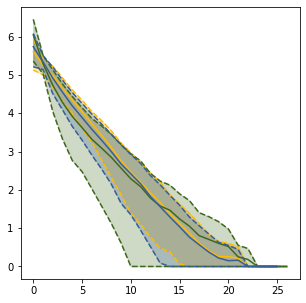

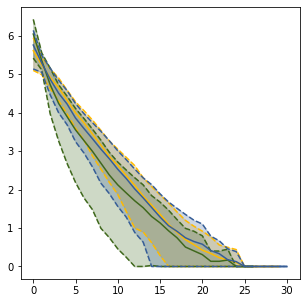

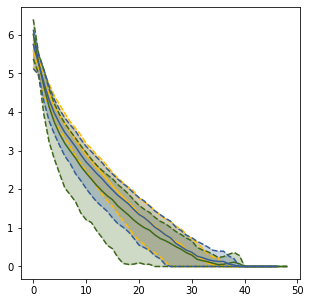

In [36]:
%matplotlib inline
plot_abundance_cont(speciation_prob='no')
plot_abundance_cont(speciation_prob='lo')
plot_abundance_cont(speciation_prob='hi')
#plot_abundance()

In [42]:
def plot_pi_cont(ax='', figsize=(5, 5), speciation_prob="no"):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    
    simdir = analysis_dir_cont
    
    logs = glob.glob("{}/*-*/*megalog.txt".format(simdir))
    params = glob.glob("{}/*-*/params-fig2.txt".format(simdir))
    brut_comp = np.array([float(open(x,'r').read().split('\n')[7].split(' ')[0]) for x in params])
    brut_filt = np.array([float(open(x,'r').read().split('\n')[6].split(' ')[0]) for x in params])
    brut_ab = [pd.read_csv(x)["pi_local"].sort_values(ascending=False).values for x in logs]
    brut_neutral = np.array([1]*len(brut_comp)) - brut_comp - brut_filt
    spec = np.array([float(open(x,'r').read().split('\n')[-2].split(' ')[0]) for x in params])
    
    
    if speciation_prob=='lo':
        sp = 0.0005
    elif speciation_prob=='no':
        sp = 0
    else:
        sp = 0.005
        
    comp, filt, neut = [], [], []
    for i in range(len(brut_comp)):
        if brut_comp[i]>brut_filt[i] and brut_comp[i]>brut_neutral[i] and spec[i]==sp:
            comp += [brut_ab[i]]
        elif brut_comp[i]<brut_filt[i] and brut_filt[i]>brut_neutral[i] and spec[i]==sp:
            filt += [brut_ab[i]]
        elif brut_neutral[i]>brut_filt[i] and brut_comp[i]<brut_neutral[i] and spec[i]==sp:
            neut += [brut_ab[i]]
    print(len(brut_ab), len(comp)+len(filt)+len(neut))
    log_comp = pd.concat(map(pd.Series, comp), axis=1)
    log_filt = pd.concat(map(pd.Series, filt), axis=1)
    log_neut = pd.concat(map(pd.Series, neut), axis=1)
    
    log_dat = [pd.read_csv(x)["pi_local"].sort_values(ascending=False).values for x in logs]

    log_df = pd.concat(map(pd.Series, log_dat), axis=1)
    mask = (log_df.notna().sum() >= 0) & (log_df.notna().sum() <= 21)
    log_df = log_df.loc[:, mask]

    #means = log_df.apply(np.mean, axis=1)
    #stds = log_df.apply(np.std, axis=1)
    #xs = range(0, len(means))
    #ax.plot(xs, means, color = 'black')
    #ax.plot(xs, means + stds, ls='--', color = 'black')
    #ax.plot(xs, means - stds, ls='--', color = 'black')
    #ax.fill_between(xs, means - stds, means + stds,
    #                alpha=0.25, color = 'black')

    means = log_comp.apply(np.mean, axis=1)
    stds = log_comp.apply(np.std, axis=1)
    xs = range(0, len(means))
    ax.plot(xs, means, color = MESS.plotting.model_colors['pairwise_competition'])
    ax.plot(xs, means + stds, ls='--', color = MESS.plotting.model_colors['pairwise_competition'])
    ax.plot(xs, means - stds, ls='--', color = MESS.plotting.model_colors['pairwise_competition'])
    ax.fill_between(xs, means - stds, means + stds,
                    alpha=0.25, color = MESS.plotting.model_colors['pairwise_competition'])
    
    means = log_filt.apply(np.mean, axis=1)
    stds = log_filt.apply(np.std, axis=1)
    xs = range(0, len(means))
    ax.plot(xs, means, color = MESS.plotting.model_colors['filtering'])
    ax.plot(xs, means + stds, ls='--', color = MESS.plotting.model_colors['filtering'])
    ax.plot(xs, means - stds, ls='--', color = MESS.plotting.model_colors['filtering'])
    ax.fill_between(xs, means - stds, means + stds,
                    alpha=0.25, color = MESS.plotting.model_colors['filtering'])
    means = log_neut.apply(np.mean, axis=1)
    stds = log_neut.apply(np.std, axis=1)
    xs = range(0, len(means))
    ax.plot(xs, means, color = MESS.plotting.model_colors['neutral'])
    ax.plot(xs, means + stds, ls='--', color = MESS.plotting.model_colors['neutral'])
    ax.plot(xs, means - stds, ls='--', color = MESS.plotting.model_colors['neutral'])
    ax.fill_between(xs, means - stds, means + stds,
                    alpha=0.25, color = MESS.plotting.model_colors['neutral'])
    
   
        

1200 400
1200 400
1200 400


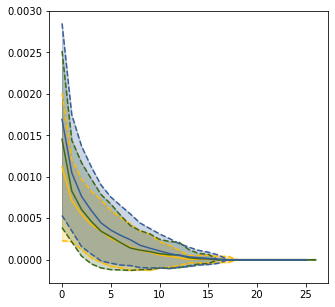

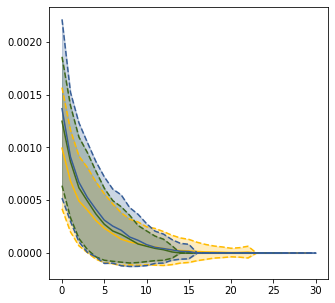

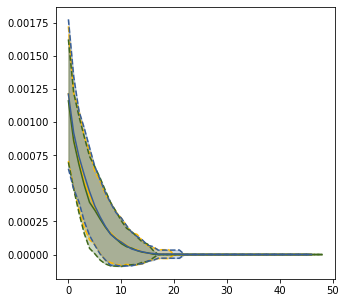

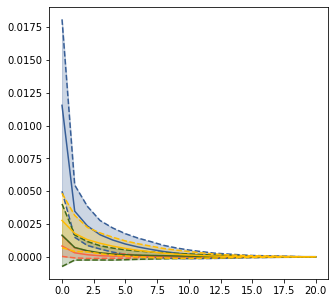

In [43]:
plot_pi_cont(speciation_prob='no')
plot_pi_cont(speciation_prob='lo')
plot_pi_cont(speciation_prob='hi')
plot_pi()

In [56]:
def plot_richness_cont(ax='', figsize=(5, 5), simfile=analysis_dir_cont + "OUT_modif.txt",\
                     speciation_prob="no", xlim=(0,50), legend=False):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    sim_df = pd.read_csv(simfile, sep="\t", header=0)
    labels = [''] * len(sim_df)
    for i in range(len(sim_df)):
        if sim_df["competition"][i]>sim_df["filtering"][i] and sim_df["competition"][i]>1-sim_df["competition"][i]-sim_df["filtering"][i]:
            labels[i]="pairwise_competition"
        elif sim_df["filtering"][i]>sim_df["competition"][i] and sim_df["filtering"][i]>1-sim_df["competition"][i]-sim_df["filtering"][i]:
            labels[i]="filtering"
        else:
            labels[i]="neutral"
    labels=np.array(labels)
    

    #labels, sim_df = MESS.plotting._filter_sims(simfile,\
    #                        feature_set=["S", "speciation_prob"],\
     #                       normalize_hills=False)

    mask = (sim_df["S"] > 1) & (sim_df["speciation_prob"] == sp_dict[speciation_prob])

    
    sim_df = sim_df[mask]
    labels = labels[mask]
    
    neut_df = sim_df[labels == "neutral"]
    filt_df = sim_df[labels == "filtering"]
    comp_df = sim_df[labels == "competition"]
    pw_df = sim_df[labels == "pairwise_competition"]

    bw_method=1.5
    ax = sns.kdeplot(neut_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["neutral"],
                    label="neutral", bw=bw_method,  legend=legend)
    ax.set_xlim(xlim)
    ax = sns.kdeplot(filt_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["filtering"],
                    label="filtering", bw=bw_method,  legend=legend)
    ax.set_xlim(xlim)
    ax = sns.kdeplot(comp_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["competition"],
                    label="mean competition", bw=bw_method,  legend=legend)
    
    ax = sns.kdeplot(pw_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["pairwise_competition"],
                    label="pairwise competition", bw=bw_method,  legend=legend)
    ax.set_xlim(xlim)

    ## If you have a legend, increase the font size
    try:
#        plt.legend(fontsize='20', loc='upper left')
        plt.setp(ax.get_legend().get_texts(), fontsize='15') 
    except:
        pass

True
False
False


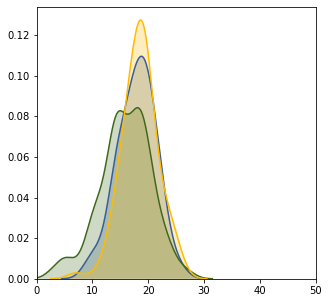

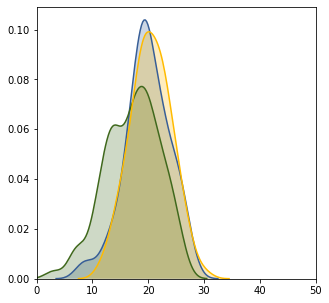

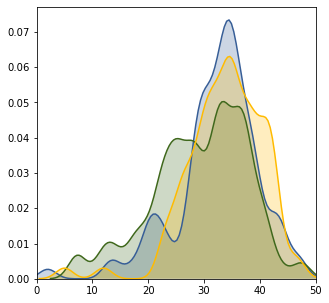

In [55]:
plot_richness_cont(speciation_prob='no')
plot_richness_cont(speciation_prob='lo')
plot_richness_cont(speciation_prob='hi')

In [57]:
def plot_traits(ax='', speciation_prob='hi', do_abs=True):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for m in models:
        simdir = analysis_dir + "{}_MESS".format(m)

        logs = glob.glob("{}/*{}-*/*megalog*".format(simdir, speciation_prob))
        log_dat = [pd.read_csv(x).sort_values(by=["abundance"], ascending=False) for x in logs]
        log_df = pd.concat(map(pd.Series, [x["trait"].values for x in log_dat]), axis=1)
        abunds = pd.concat(map(pd.Series, [x["abundance"].values for x in log_dat]), axis=1)
        #display(log_df)
        #mask = (log_df.notna().sum() >= 3) & (log_df.notna().sum() <= 21)
        #log_df = log_df.loc[:, mask]
        #mask = (abunds.notna().sum() >= 3) & (abunds.notna().sum() <= 21)
        #abunds = abunds.loc[:, mask]

        col_means = log_df.mean()
        col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
        if do_abs:
            log_df = pd.DataFrame(np.abs(log_df.values - col_means_vec))
        else:
            log_df = pd.DataFrame(log_df.values - col_means_vec)
        
        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))
        ax.plot(xs, means, c=MESS.plotting.model_colors[m])
        ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.plot(xs, means - stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.fill_between(xs, means - stds, means + stds, alpha=0.2, color=MESS.plotting.model_colors[m])

        ## Plot the average RAD
        #ax.plot(xs, np.log(abunds.apply(np.mean, axis=1)), c=MESS.plotting.model_colors[m])
        #ax.set_title(sp_prob, fontsize=20)

In [47]:
def plot_traits_cont(ax='', speciation_prob='hi', do_abs=True):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    simdir = analysis_dir_cont

    logs = glob.glob("{}/*-*/*megalog.txt".format(simdir))
    log_dat = [pd.read_csv(x).sort_values(by=["abundance"], ascending=False) for x in logs]
    log_df = pd.concat(map(pd.Series, [x["trait"].values for x in log_dat]), axis=1)
    abunds = pd.concat(map(pd.Series, [x["abundance"].values for x in log_dat]), axis=1)
    #display(log_df)
    #mask = (log_df.notna().sum() >= 3) & (log_df.notna().sum() <= 21)
    #log_df = log_df.loc[:, mask]
    #mask = (abunds.notna().sum() >= 3) & (abunds.notna().sum() <= 21)
    #abunds = abunds.loc[:, mask]

    params = glob.glob("{}/*-*/params-fig2.txt".format(simdir))
    brut_comp = np.array([float(open(x,'r').read().split('\n')[7].split(' ')[0]) for x in params])
    brut_filt = np.array([float(open(x,'r').read().split('\n')[6].split(' ')[0]) for x in params])
    #brut_ab = [pd.read_csv(x)["traits"].sort_values(ascending=False).values for x in logs]
    brut_neutral = np.array([1]*len(brut_comp)) - brut_comp - brut_filt
    spec = np.array([float(open(x,'r').read().split('\n')[-2].split(' ')[0]) for x in params])

    if speciation_prob=='lo':
        sp = 0.0005
    elif speciation_prob=='no':
        sp = 0
    else:
        sp = 0.005
        
    comp, filt, neut = [], [], []
    for i in range(len(brut_comp)):
        if brut_comp[i]>brut_filt[i] and brut_comp[i]>brut_neutral[i] and spec[i]==sp:
            comp += [log_df[i]]
        elif brut_comp[i]<brut_filt[i] and brut_filt[i]>brut_neutral[i] and spec[i]==sp:
            filt += [log_df[i]]
        elif brut_neutral[i]>brut_filt[i] and brut_comp[i]<brut_neutral[i] and spec[i]==sp:
            neut += [log_df[i]]

    log_comp = pd.concat(map(pd.Series, comp), axis=1)
    log_filt = pd.concat(map(pd.Series, filt), axis=1)
    log_neut = pd.concat(map(pd.Series, neut), axis=1)

    col_means = log_df.mean()
    col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
    if do_abs:
        log_df = pd.DataFrame(np.abs(log_df.values - col_means_vec))
    else:
        log_df = pd.DataFrame(log_df.values - col_means_vec)

    #means = log_df.apply(np.mean, axis=1)
    #stds = log_df.apply(np.std, axis=1)
    #xs = range(0, len(means))
    #ax.plot(xs, means, c='black')
    #ax.plot(xs, means + stds, c='black', ls='--')
    #ax.plot(xs, means - stds, c='black', ls='--')
    #ax.fill_between(xs, means - stds, means + stds, alpha=0.2, color='black')

    col_means = log_comp.mean()
    col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
    if do_abs:
        log_comp = pd.DataFrame(np.abs(log_comp.values - col_means_vec))
    else:
        log_comp = pd.DataFrame(log_comp.values - col_means_vec)
        
    means = log_comp.apply(np.mean, axis=1)
    stds = log_comp.apply(np.std, axis=1)
    xs = range(0, len(means))
    ax.plot(xs, means, color = MESS.plotting.model_colors['pairwise_competition'])
    ax.plot(xs, means + stds, ls='--', color = MESS.plotting.model_colors['pairwise_competition'])
    ax.plot(xs, means - stds, ls='--', color = MESS.plotting.model_colors['pairwise_competition'])
    ax.fill_between(xs, means - stds, means + stds,
                    alpha=0.25, color = MESS.plotting.model_colors['pairwise_competition'])

    col_means = log_filt.mean()
    col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
    if do_abs:
        log_filt = pd.DataFrame(np.abs(log_filt.values - col_means_vec))
    else:
        log_filt = pd.DataFrame(log_filt.values - col_means_vec)
        
    means = log_filt.apply(np.mean, axis=1)
    stds = log_filt.apply(np.std, axis=1)
    xs = range(0, len(means))
    ax.plot(xs, means, color = MESS.plotting.model_colors['filtering'])
    ax.plot(xs, means + stds, ls='--', color = MESS.plotting.model_colors['filtering'])
    ax.plot(xs, means - stds, ls='--', color = MESS.plotting.model_colors['filtering'])
    ax.fill_between(xs, means - stds, means + stds,
                    alpha=0.25, color = MESS.plotting.model_colors['filtering'])
    
    col_means = log_neut.mean()
    col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
    if do_abs:
        log_neut = pd.DataFrame(np.abs(log_neut.values - col_means_vec))
    else:
        log_neut = pd.DataFrame(log_neut.values - col_means_vec)
    
    means = log_neut.apply(np.mean, axis=1)
    stds = log_neut.apply(np.std, axis=1)
    xs = range(0, len(means))
    ax.plot(xs, means, color = MESS.plotting.model_colors['neutral'])
    ax.plot(xs, means + stds, ls='--', color = MESS.plotting.model_colors['neutral'])
    ax.plot(xs, means - stds, ls='--', color = MESS.plotting.model_colors['neutral'])
    ax.fill_between(xs, means - stds, means + stds,
                alpha=0.25, color = MESS.plotting.model_colors['neutral'])
    ## Plot the average RAD
    #ax.plot(xs, np.log(abunds.apply(np.mean, axis=1)), c=MESS.plotting.model_colors[m])
    #ax.set_title(sp_prob, fontsize=20)

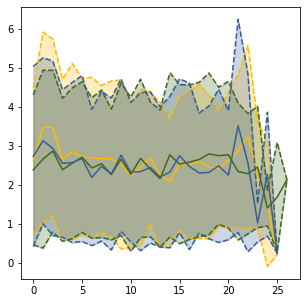

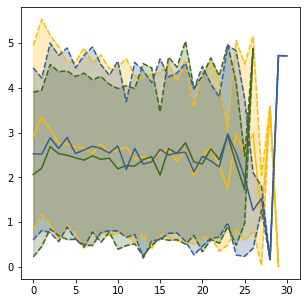

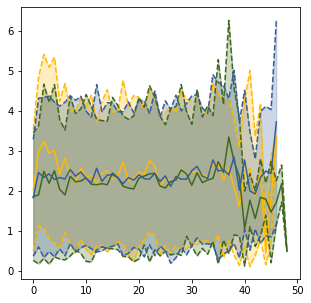

In [48]:
plot_traits_cont(speciation_prob='no')
plot_traits_cont(speciation_prob='lo')
plot_traits_cont(speciation_prob='hi')

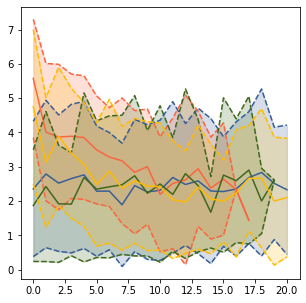

In [77]:
plot_traits(speciation_prob="no", do_abs=True)

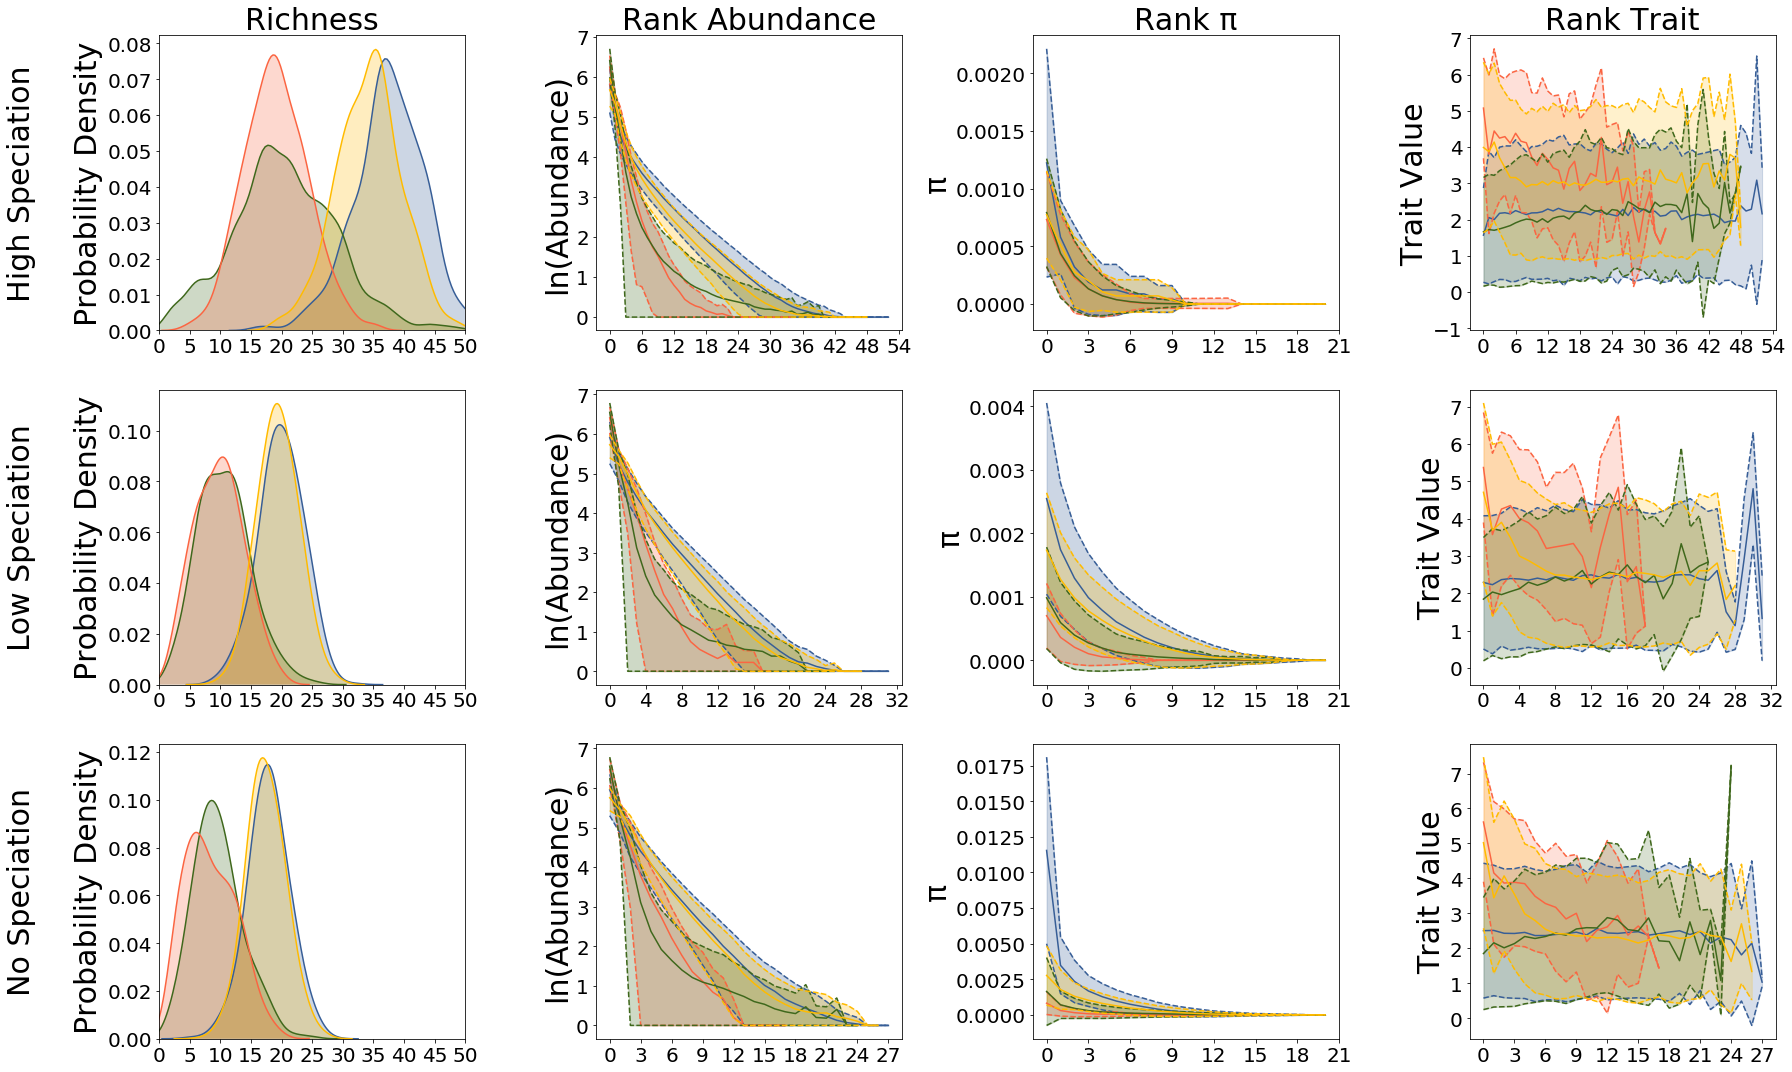

In [11]:
funcs = {"Richness":plot_richness,
         "Rank Abundance":plot_abundance,
         u"Rank π":plot_pi,
         "Rank Trait":plot_traits}
sp_title_dict = {"no":"No", "lo":"Low", "hi":"High"}

fig, axs = plt.subplots(3, 4, figsize=(25, 15))
for i, sp in enumerate(["hi", "lo", "no"]):
    for j, f in enumerate(["Richness", "Rank Abundance", u"Rank π", "Rank Trait"]):
        #if i == 0 and j == 0:
        #        funcs[f](ax=axs[i][j], speciation_prob=sp, legend=True)
        funcs[f](ax=axs[i][j], speciation_prob=sp)

        ## Labeling and cleaning up the plots
        if i % 4 == 0:
            axs[i][j].set_title(f, fontsize=30)
        if j % 4 == 0:
            axs[i][j].set_ylabel("{} Speciation\n\nProbability Density".format(sp_title_dict[sp]), fontsize=30)
        if j % 4 == 1:
            axs[i][j].set_ylabel("ln(Abundance)", fontsize=30)
        if j % 4 == 2:
            axs[i][j].set_ylabel(u"π", fontsize=30)
        if j % 4 == 3:
            axs[i][j].set_ylabel("Trait Value", fontsize=30)
        ## Cast xtick labelsto int
        axs[i][j].xaxis.set_major_locator(MaxNLocator(integer=True))
        
## Make axis ticklabels easier to read
axs = axs.flatten()
_ = [plt.setp(ax.get_xticklabels(), fontsize=20) for ax in axs.flatten()]
_ = [plt.setp(ax.get_yticklabels(), fontsize=20) for ax in axs.flatten()]

plt.tight_layout()

1200 400
1200 400
1200 400


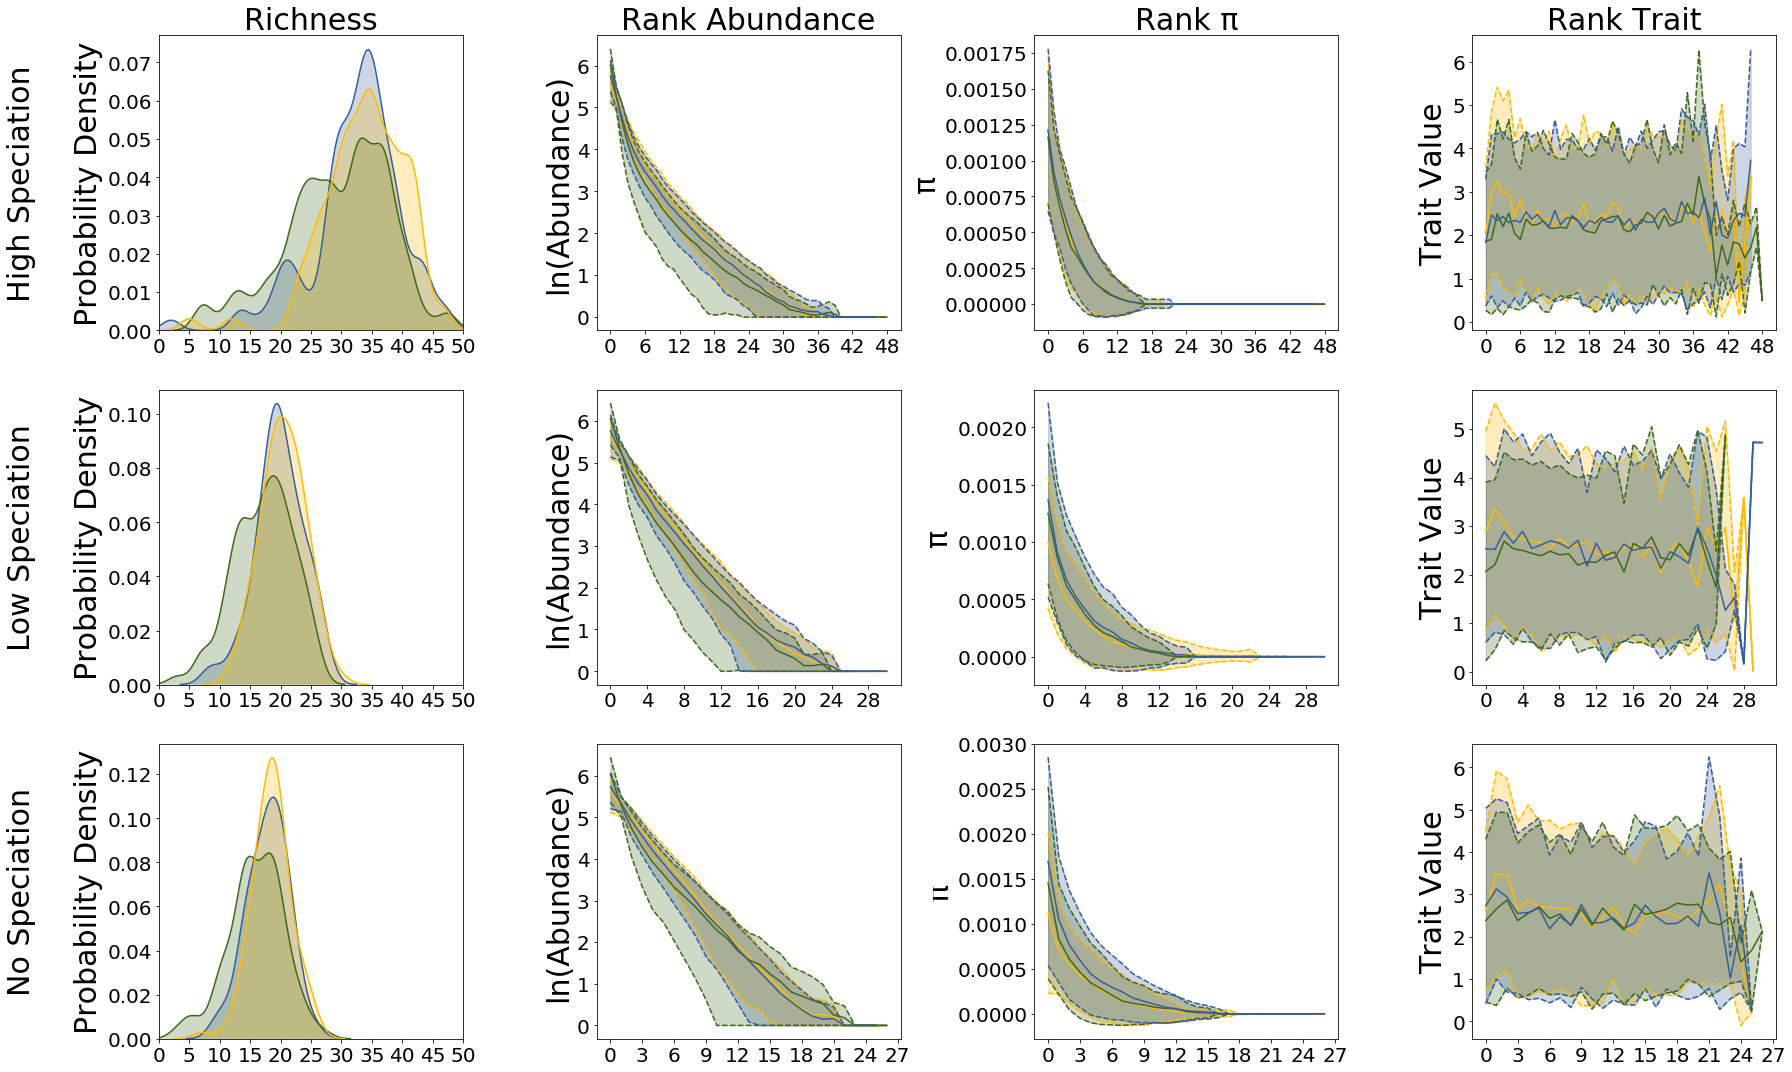

In [58]:
funcs = {"Richness":plot_richness_cont,
         "Rank Abundance":plot_abundance_cont,
         u"Rank π":plot_pi_cont,
         "Rank Trait":plot_traits_cont}
sp_title_dict = {"no":"No", "lo":"Low", "hi":"High"}

fig, axs = plt.subplots(3, 4, figsize=(25, 15))
for i, sp in enumerate(["hi", "lo", "no"]):
    for j, f in enumerate(["Richness", "Rank Abundance", u"Rank π", "Rank Trait"]):
        #if i == 0 and j == 0:
        #        funcs[f](ax=axs[i][j], speciation_prob=sp, legend=True)
        funcs[f](ax=axs[i][j], speciation_prob=sp)

        ## Labeling and cleaning up the plots
        if i % 4 == 0:
            axs[i][j].set_title(f, fontsize=30)
        if j % 4 == 0:
            axs[i][j].set_ylabel("{} Speciation\n\nProbability Density".format(sp_title_dict[sp]), fontsize=30)
        if j % 4 == 1:
            axs[i][j].set_ylabel("ln(Abundance)", fontsize=30)
        if j % 4 == 2:
            axs[i][j].set_ylabel(u"π", fontsize=30)
        if j % 4 == 3:
            axs[i][j].set_ylabel("Trait Value", fontsize=30)
        ## Cast xtick labelsto int
        axs[i][j].xaxis.set_major_locator(MaxNLocator(integer=True))
        
## Make axis ticklabels easier to read
axs = axs.flatten()
_ = [plt.setp(ax.get_xticklabels(), fontsize=20) for ax in axs.flatten()]
_ = [plt.setp(ax.get_yticklabels(), fontsize=20) for ax in axs.flatten()]

plt.tight_layout()

/home/juliette/Documents/internship_m1_MESS/MESS/fig2/neutral_MESS/neutral-no-506166938/island1-0.755-megalog.txt


,name,trait,abundance,Ne_local,Ne_meta,tdiv,growth_rate,migration_rate,segsites_tot,pi_tot,segsites_local,segsites_meta,pi_local,pi_meta,dxy,da,TajimaD
0,64.0,-6.699726,50,1.307402e+04,13790,86114,0,1.243498e-08,2,0.001690,1,1,0.000936,0.000351,0.002632,0.001988,1.390094
1,239.0,3.458502,228,3.964245e+04,29825,193648,0,6.122437e-09,9,0.006150,4,2,0.003431,0.000702,0.009825,0.007758,1.601740
2,67.0,-3.975738,40,9.010098e+03,4918,58541,0,1.895878e-09,1,0.000175,0,1,0.000000,0.000351,0.000175,0.000000,0.000000
3,110.0,2.608948,133,1.059110e+04,4449,61463,0,3.072380e-09,1,0.000175,0,1,0.000000,0.000351,0.000175,0.000000,0.000000
4,89.0,-5.370929,1,2.000000e+03,11048,4297,0,0.000000e+00,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
5,59.0,-4.026160,107,7.761146e+03,9668,43297,0,2.975886e-08,1,0.000175,0,1,0.000000,0.000351,0.000175,0.000000,0.000000
6,90.0,-4.293689,46,1.822671e+04,14965,67440,0,5.694717e-09,1,0.000175,0,1,0.000000,0.000351,0.000175,0.000000,0.000000
7,114.0,-8.459969,246,1.190393e+06,52950,246000,0,3.858806e-10,27,0.010166,20,5,0.009786,0.004678,0.012807,0.005575,-0.831532
8,3.0,-4.289625,6,3.200000e+03,36824,5197,0,1.202617e-07,6,0.003047,0,6,0.000000,0.005068,0.003509,0.000975,0.000000
9,175.0,3.890356,2,2.000000e+03,25437,1192,0,0.000000e+00,1,0.000175,0,1,0.000000,0.000351,0.000175,0.000000,0.000000


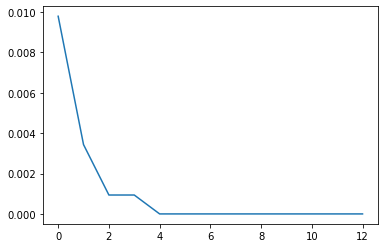

In [79]:
simdir = analysis_dir + "neutral_MESS"
logs = glob.glob("{}/*no-*/*megalog*".format(simdir))
print(logs[-1])
df = pd.read_csv(logs[-1])
pis = df["pi_local"]
xs = range(0, len(pis))
ys = sorted(pis, reverse=True)
plt.plot(xs, ys)
df

Removed invariant targets. Retained: ['S']
Nsims
  neutral	216
  filtering	197
  competition	120
 pairwise_competition	257


array([<matplotlib.axes._subplots.AxesSubplot object at 0x6fd832ca0890>],
      dtype=object)

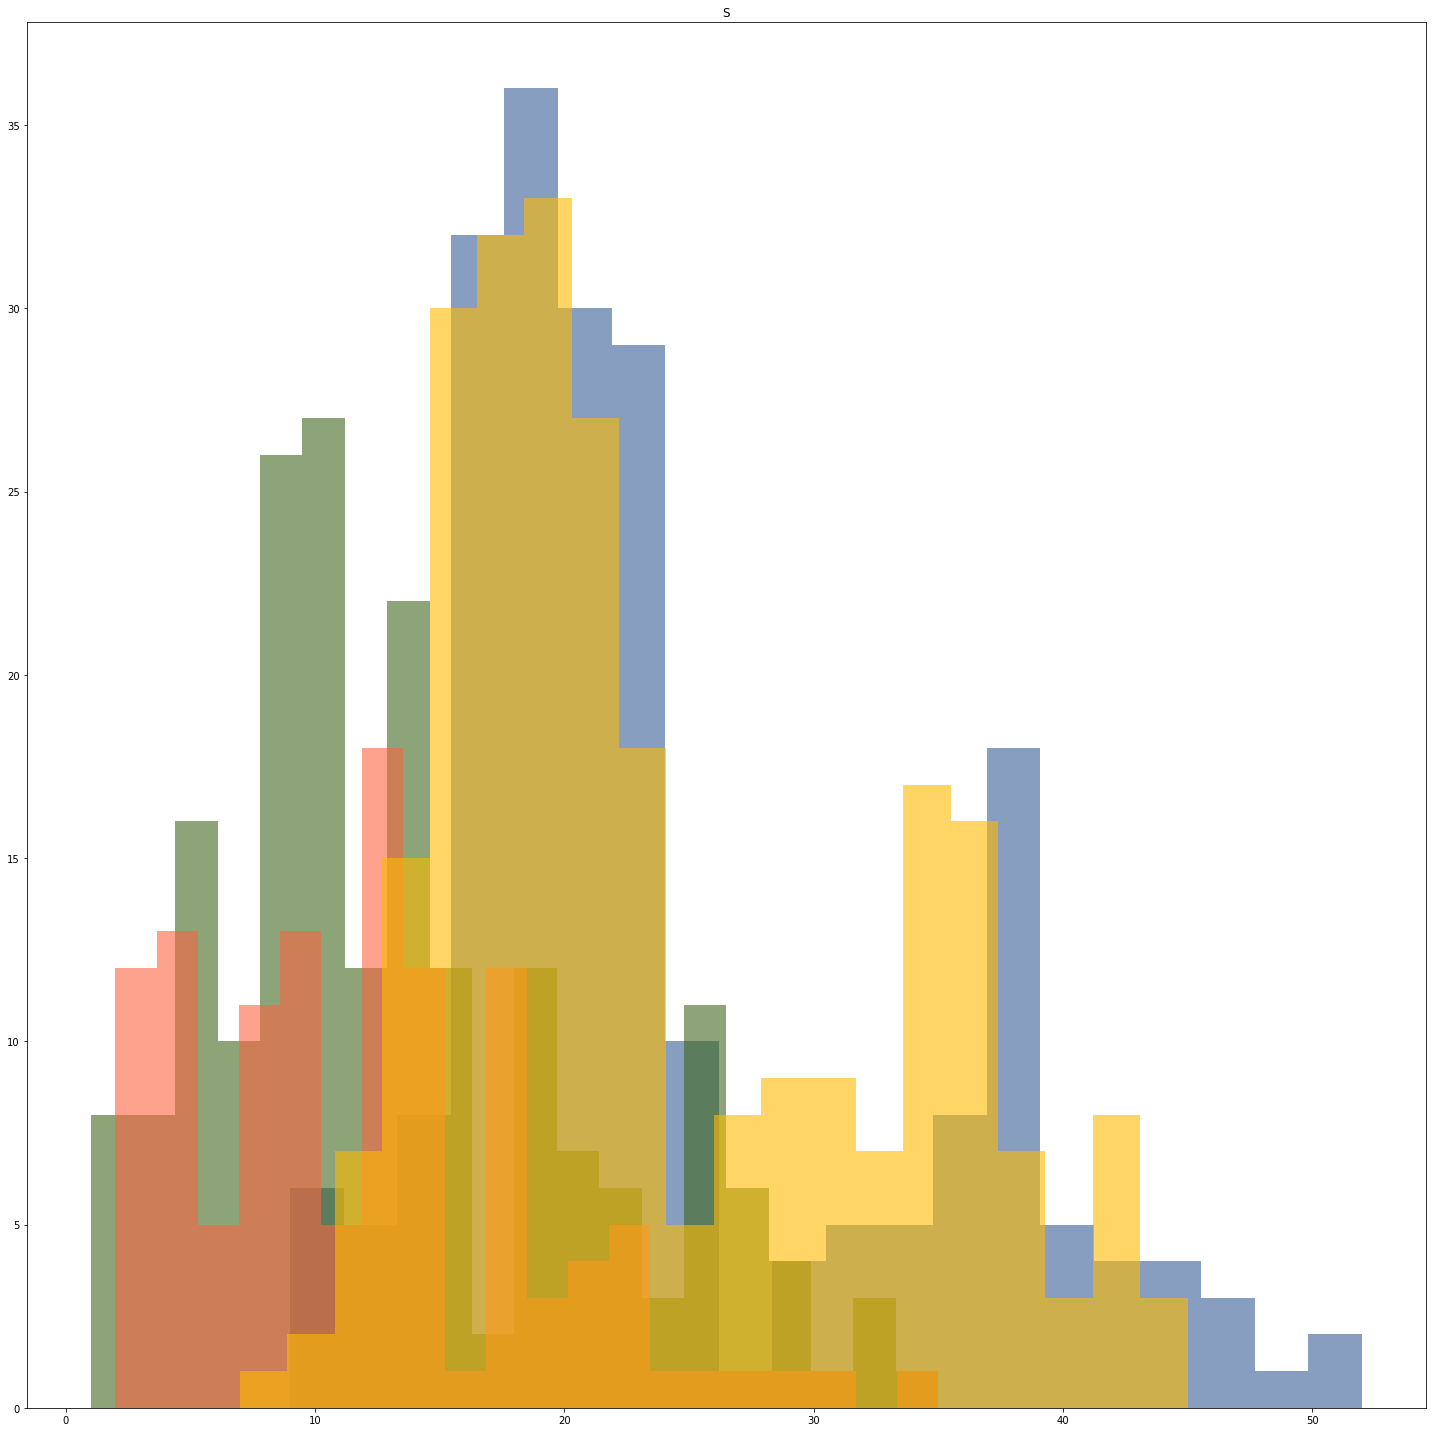

In [80]:
simfile = analysis_dir + "OUT_modif.txt"
#simfile = analysis_dir + "SIMOUT.txt"
sim_df = pd.read_csv(simfile, sep="\t", header=0)
MESS.plotting.plot_simulations_hist(simfile, verbose=True, normalize_hills=False,\
                                        feature_set=["S"])

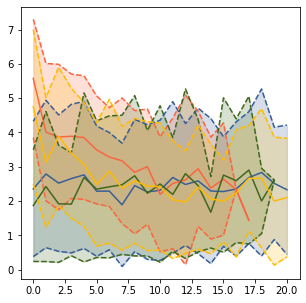

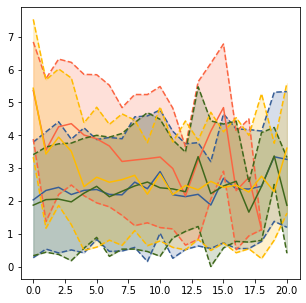

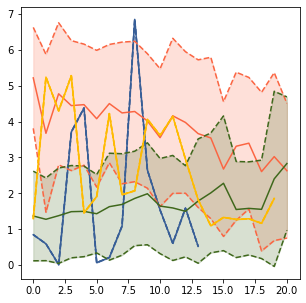

In [81]:

#plot_traits(speciation_prob="no", do_abs=False)
plot_traits(speciation_prob="no", do_abs=True)
plot_traits(speciation_prob="lo", do_abs=True)
plot_traits(speciation_prob="hi", do_abs=True)


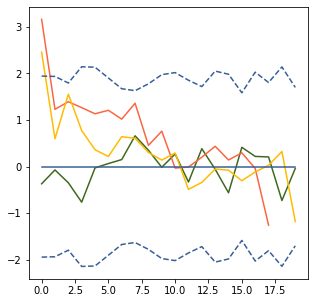

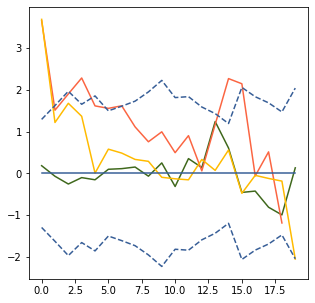

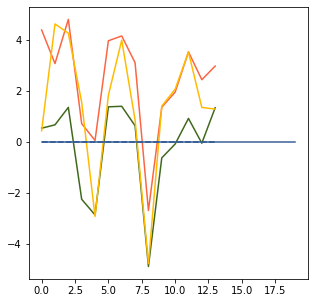

In [82]:
def plot_traits_residuals(ax='', sp_prob='hi'):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    mean_dict = {}
    std_dict = {}
    for m in models:
        simdir = analysis_dir + "{}_MESS".format(m)

        logs = glob.glob("{}/*{}-*/*megalog*".format(simdir, sp_prob))
        log_dat = [pd.read_csv(x).sort_values(by=["abundance"], ascending=False) for x in logs]
        log_df = pd.concat(map(pd.Series, [x["trait"].values for x in log_dat]), axis=1)
        abunds = pd.concat(map(pd.Series, [x["abundance"].values for x in log_dat]), axis=1)
        #display(log_df)
        mask = (log_df.notna().sum() >= 5) & (log_df.notna().sum() <= 20)
        log_df = log_df.loc[:, mask]
        mask = (abunds.notna().sum() >= 5) & (abunds.notna().sum() <= 20)
        abunds = abunds.loc[:, mask]

        col_means = log_df.mean()
        col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
        log_df = pd.DataFrame(np.abs(log_df.values - col_means_vec))

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        mean_dict[m] = means[:24]
        std_dict[m] = stds[:24]

    for m in ["filtering", "competition","pairwise_competition"]:
        xs = range(0, len(mean_dict["neutral"]))
        means = (mean_dict[m] - mean_dict["neutral"])
        stds = (std_dict[m] - std_dict["neutral"])
        ax.plot(xs, means, c=MESS.plotting.model_colors[m])
        #ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
        #ax.plot(xs, means - stds, c=MESS.plotting.model_colors[m], ls='--')
        #ax.fill_between(xs, means - stds, means + stds, alpha=0.2, color=MESS.plotting.model_colors[m])
    xs = range(0, 20)
    ax.plot(xs, [0]*len(xs), color=MESS.plotting.model_colors["neutral"])
    ax.plot(xs, 0 + std_dict["neutral"][:20], c=MESS.plotting.model_colors["neutral"], ls='--')
    ax.plot(xs, 0 - std_dict["neutral"][:20], c=MESS.plotting.model_colors["neutral"], ls='--')

plot_traits_residuals(sp_prob="no")
plot_traits_residuals(sp_prob="lo")
plot_traits_residuals(sp_prob="hi")

In [83]:
mn = log_df[0].mean()
print(mn)
np.abs(log_df[0] - mn) * abunds.iloc[:, 0]

NameError: name 'log_df' is not defined

NameError: name 'df_dict' is not defined

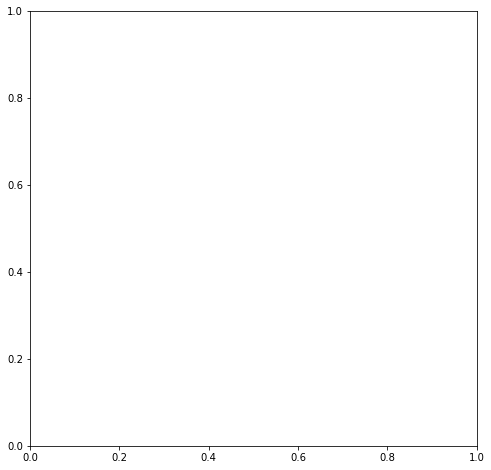

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))
traits = True

for m in models:
    df_dict[m] = pd.DataFrame()
    simdir = analysis_dir + "{}_MESS/".format(m)

    for sp in ["lo"]:
        logs = glob.glob("{}/*{}-*/*megalog.txt".format(simdir, sp))
        log_dat = [pd.read_csv(x)["trait"].sort_values(ascending=False).values for x in logs]
        
        log_df = pd.concat(map(pd.Series, log_dat), axis=1)
        mask = log_df.notna().sum() == 17
        log_df = log_df.loc[:, mask]

        if traits:
            col_means = log_df.mean()
            col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
            log_df = pd.DataFrame(abs(log_df.values - col_means_vec))

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))

        ax.plot(xs, means, c=MESS.plotting.model_colors[m])
        ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.plot(xs, means - stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.fill_between(xs, means - stds, means + stds, color=MESS.plotting.model_colors[m],alpha=0.5)


In [ ]:
# fit an array of size [Ndim, Nsamples]
data = np.vstack([x, y])
kde = gaussian_kde(data)

# evaluate on a regular grid
xgrid = np.linspace(-3.5, 3.5, 40)
ygrid = np.linspace(-6, 6, 40)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Plot the result as an image
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[-3.5, 3.5, -6, 6],
           cmap='Blues')
cb = plt.colorbar()
cb.set_label("density")

## Trash below here

Figure 2 Dev

In [ ]:
df_dict = {}
fig, ax = plt.subplots(figsize=(5, 5))
traits = False

for m in models:
    df_dict[m] = pd.DataFrame()
    simdir = analysis_dir + "{}_MESS/".format(m)

    for sp in ["no"]:
        logs = glob.glob("{}/*{}-*/*megalog.txt".format(simdir, sp))[:50]

        log_dat = [pd.read_csv(x)["abundance"].sort_values(ascending=False).values for x in logs]
        
        log_df = pd.concat(map(pd.Series, log_dat), axis=1)
        mask = log_df.notna().sum() == 15
        log_df = log_df.loc[:, mask]

        if traits:
            col_means = log_df.mean()
            col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
            log_df = pd.DataFrame(log_df.values - col_means_vec)

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))
        if True:
            ax.plot(xs, np.log(means), c=MESS.plotting.model_colors[m])
            ax.plot(xs, np.log(means + stds), c=MESS.plotting.model_colors[m], ls='--')
            ax.plot(xs, np.log(np.clip(means - stds, 1, a_max=None)), color=MESS.plotting.model_colors[m], ls='--')
            ax.fill_between(xs, np.log(np.clip(means - stds, 1, a_max=None)), np.log(means + stds),
                            color=MESS.plotting.model_colors[m], alpha=0.25)
        else:
            ax.plot(xs, means, c=MESS.plotting.model_colors[m])
            ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
            ax.plot(xs, means - stds, color=MESS.plotting.model_colors[m], ls='--')
            ax.fill_between(xs, means - stds, means + stds,
                            color=MESS.plotting.model_colors[m], alpha=0.25)


The RAC version is unparsable.

In [ ]:
models = ["neutral", "competition", "filtering", "pairwise_competition"]
df_dict = {}
for m in models:
    df_dict[m] = pd.DataFrame()
    simdir = analysis_dir + "{}_MESS/".format(m)
    for sp in ["hi"]:
        dirs = glob.glob("{}/{}-*".format(simdir, sp))[:50]
        for d in dirs:
            try:
                df = pd.read_csv(glob.glob("{}/*megalog*".format(d))[0])
            except:
                pass
            pis = df["abundance"]
            xs = range(0, len(pis))
            ys = np.log(sorted(pis, reverse=True))
            #ys = sorted(pis, reverse=True)
            plt.plot(xs, ys, c=MESS.plotting.model_colors[m], alpha=0.3)
            #plt.xlim(0, 15)